# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Advanced Lane Finding Project

In this notebook, functionality is implemented in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, Python code is successfully imported and included in this submission. 

### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
### Import Required Libraries

In [81]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import glob
import time

%matplotlib inline

### Load the Training Data and Visualize random images.

Car Images Size:  8792 
Non-Car Images Size:  8968


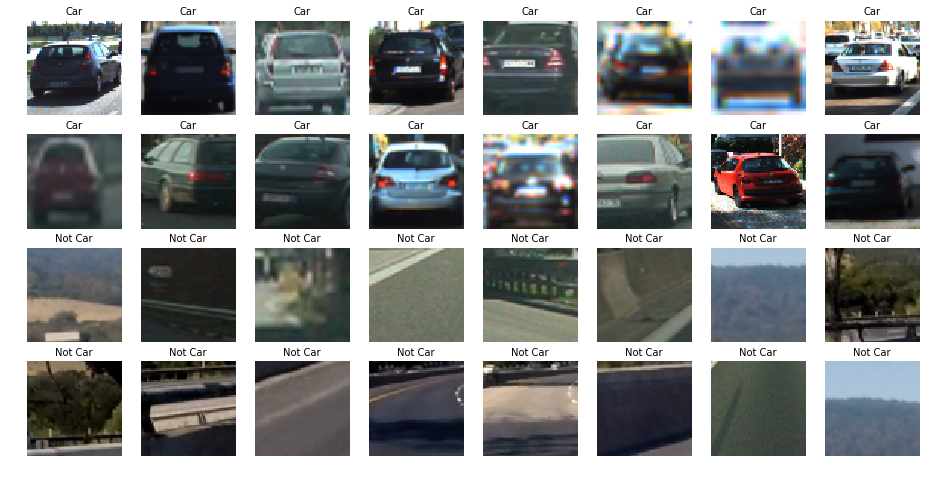

In [82]:
# Test Data is divided into two classes `vehicles` and `not-vehicles` where as 
# the name suggests first class includes all the images of car type objects 
# and the second class includes images of non-car typoe objects.

# Vehicle Class Images
vehicles = glob.glob('dataset/vehicles/**/*.png')
# Non-Vehicle Class Images
not_vehicles = glob.glob('dataset/non-vehicles/**/*.png')
# Print the number of images in each class.
print('Car Images Size: ', len(vehicles), '\nNon-Car Images Size: ', len(not_vehicles))

# Visualize Dataset.
fig, vaxis = plt.subplots(4,8, figsize=(16, 8))
vaxis = vaxis.ravel()

# Plot the images from Vehicle class
for i in np.arange(16):
    img = cv2.imread(vehicles[np.random.randint(0,len(vehicles))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    vaxis[i].axis('off')
    vaxis[i].set_title('Car', fontsize=10)
    vaxis[i].imshow(img)

# Plot the images from Not Vehicle class
for i in np.arange(16,32):
    img = cv2.imread(not_vehicles[np.random.randint(0,len(not_vehicles))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    vaxis[i].axis('off')
    vaxis[i].set_title('Not Car', fontsize=10)
    vaxis[i].imshow(img)

### HOG Features & Visualization

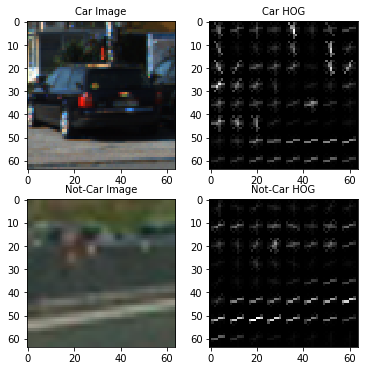

In [83]:
# Function to return HOG features.
# This code is referenced from the lectures.
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.features.hog() function to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        # Use skimage.features.hog() function to get features only
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Visualize HOG
# Read the images
img_vehicle = mpimg.imread(vehicles[5])
img_notvehicle = mpimg.imread(not_vehicles[5])
# Call get_hog_features() function with tuned parameters and vis enabled and plot the hog image.
car_feat, car_hog = get_hog_features(img_vehicle[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
notcar_feat, notcar_hog = get_hog_features(img_notvehicle[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Plot the Images
fig, ((vaxis1, vaxis2), (vaxis3, vaxis4)) = plt.subplots(2, 2, figsize=(6,6))
vaxis1.imshow(img_vehicle)
vaxis1.set_title('Car Image', fontsize=10)
vaxis2.imshow(car_hog, cmap='gray')
vaxis2.set_title('Car HOG', fontsize=10)
vaxis3.imshow(img_notvehicle)
vaxis3.set_title('Not-Car Image', fontsize=10)
vaxis4.imshow(notcar_hog, cmap='gray')
vaxis4.set_title('Not-Car HOG', fontsize=10)
plt.show()

### Extract HOG Features from an Array of Car and Non-Car Images

In [84]:
# Function to extract features from a list of images
# This function can also be used to call bin_spatial() and color_hist()
# To extract flattened spatial color features and color histogram 
# features and combine them all (making use of StandardScaler)
# to be used together for classification
# This code is referenced from lectures.
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in images one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new features vector to the features list
        features.append(hog_features)
    # Return list of features vectors
    return features

### Extract Features for Input Datasets and Combine 
#### Define Labels Vector, Shuffle and Split

In [85]:
# Feature extraction parameters
colorspace = 'YUV' # pick from RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # pick from 0, 1, 2, or "ALL"

timer1 = time.time()
# Extracting Vehicle features
car_features = extract_features(vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
# Extractng Not-Vehicle features
notcar_features = extract_features(not_vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
timer2 = time.time()
# Print time taken for extraction of HOG features.
print('Took', round(timer2-timer1, 2), 'seconds to extract HOG features!')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
random_set = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_set)

print('Orientations:', orient, '\npixels per cell:', pix_per_cell, '\ncells per block:', cell_per_block)
print('Feature vector length:', len(X_train[0]))

Took 79.19 seconds to extract HOG features!
Orientations: 11 
pixels per cell: 16 
cells per block: 2
Feature vector length: 1188


### Train a Classifier

In [86]:
# Using linear SVC for training data.
svc = LinearSVC()
# Check training time for SVC
timer1 = time.time()
# Training svc with X_train & y_train (i.e., dataset & labels)
svc.fit(X_train, y_train)
timer2 = time.time()
# Print time taken for training SVC.
print('Took', round(timer2-timer1, 2), 'seconds to train SVC!')
# Print test accuracy of SVC.
print('Test Accuracy of SVC: ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
timer1 = time.time()
n_predict = 10
print('SVC prediction is  : ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
timer2 = time.time()
print('Took', round(timer2-timer1, 5), 'seconds to predict', n_predict,'labels with SVC')

Took 1.59 seconds to train SVC!
Test Accuracy of SVC:  0.984
SVC prediction is  :  [ 1.  1.  1.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
Took 0.00317 seconds to predict 10 labels with SVC


### Method for Using Classifier to Detect Cars in an Image

In [87]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def detect(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_blocks=False):
    
    # array of blocks where cars were detected
    blocks = []
    
    img = img.astype(np.float32)/255
    
    img_test = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_test = cv2.cvtColor(img_test, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_test = cv2.cvtColor(img_test, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_test = cv2.cvtColor(img_test, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_test = cv2.cvtColor(img_test, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_test = cv2.cvtColor(img_test, cv2.COLOR_RGB2YCrCb)
    else: ctrans_test = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_test.shape
        ctrans_test = cv2.resize(ctrans_test, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_test[:,:,0]
        ch2 = ctrans_test[:,:,1]
        ch3 = ctrans_test[:,:,2]
    else: 
        ch1 = ctrans_test[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_blocks:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                blocks.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return blocks

#### Test detect on an Example Image

In [88]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # pick from RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # pick from 0, 1, 2, or "ALL"

blocks = detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(blocks), 'blocks found in image')

6 blocks found in image


#### Method to Draw Blocks onto an Image

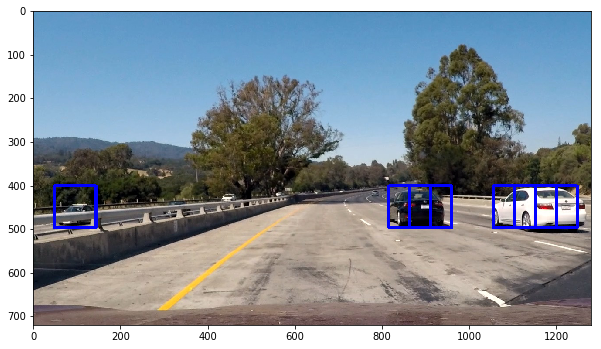

In [89]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

test_img_rects = draw_boxes(test_img, blocks)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

### Show All Potential Search Areas

Number of boxes:  78


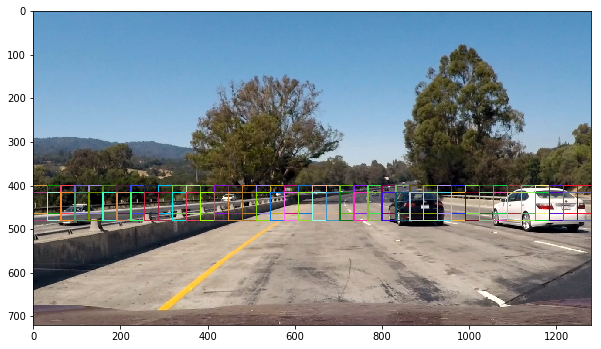

In [90]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_blocks=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_blocks=True))

blocks = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, blocks, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(blocks))

Number of boxes:  50


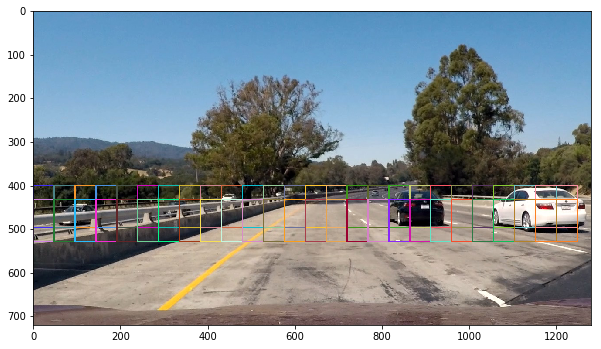

In [91]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_blocks=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_blocks=True))

blocks = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, blocks, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(blocks))

Number of boxes:  38


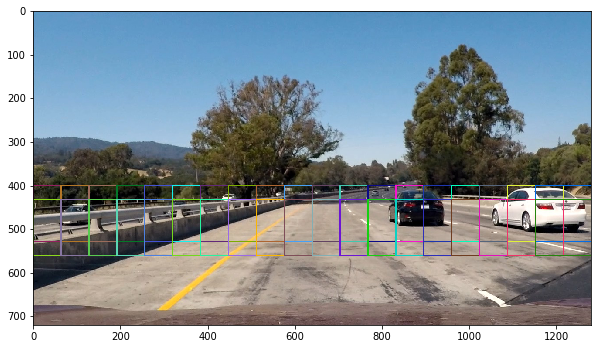

In [92]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_blocks=True))
ystart = 432
ystop = 560
scale = 2.0
rects.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_blocks=True))

blocks = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, blocks, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(blocks))

Number of boxes:  24


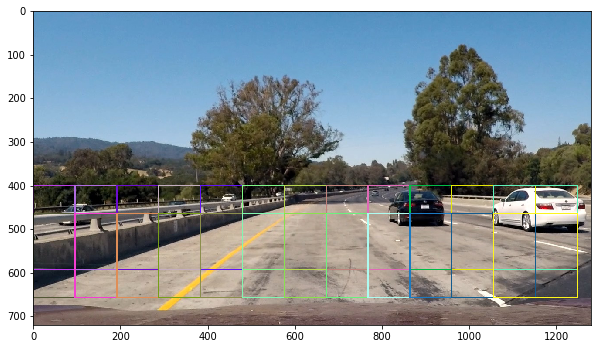

In [93]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_blocks=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_blocks=True))

blocks = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, blocks, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(blocks))

#### Combine Various Sliding Window Searches

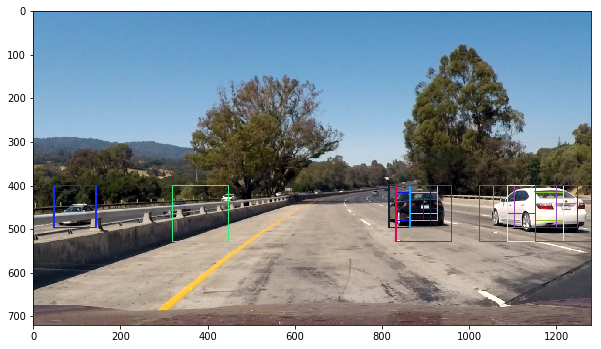

In [94]:
test_img = mpimg.imread('./test_images/test1.jpg')

blocks = []

colorspace = 'YUV' # pick from RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # pick from 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
blocks.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
blocks.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
blocks.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
blocks.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
blocks.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
blocks.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
blocks.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
blocks.append(detect(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
blocks = [item for sublist in blocks for item in sublist] 
test_img_rects = draw_boxes(test_img, blocks, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

### Heatmap

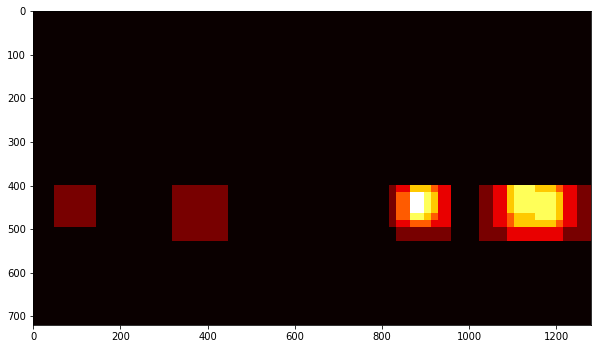

In [95]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Test out the heatmap
img_heat = np.zeros_like(test_img[:,:,0])
img_heat = add_heat(img_heat, blocks)
plt.figure(figsize=(10,10))
plt.imshow(img_heat, cmap='hot')
plt.show()

### Apply a Threshold to the Heatmap

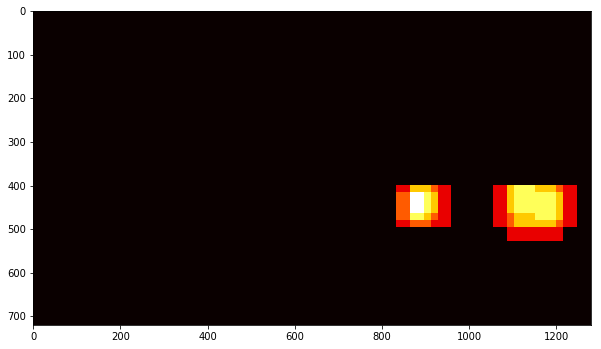

In [96]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Test out the threshold
img_heat = apply_threshold(img_heat, 1)
plt.figure(figsize=(10,10))
plt.imshow(img_heat, cmap='hot')
plt.show()

### Apply SciPy Labels to Heatmap

2 cars found


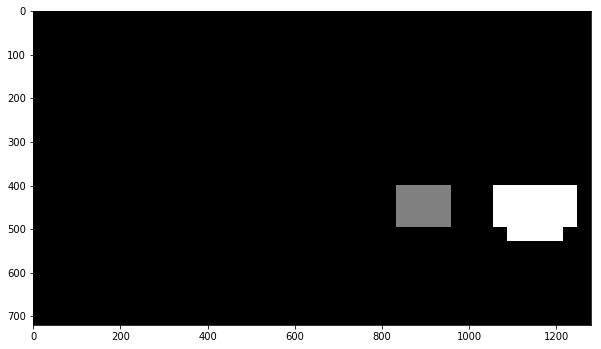

In [97]:
labels = label(img_heat)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes for Lables

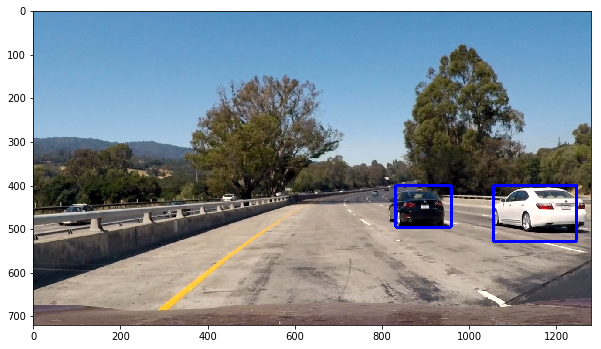

In [98]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final blocks
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.show()

### Pipeline for single frame

In [99]:
def process_frame(img):

    blocks = []

    colorspace = 'YUV' # pick from RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # pick from 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    blocks = [item for sublist in blocks for item in sublist] 
    
    img_heat = np.zeros_like(img[:,:,0])
    img_heat = add_heat(img_heat, blocks)
    img_heat = apply_threshold(img_heat, 1)
    labels = label(img_heat)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

#### Run the pipeline on all the test images.

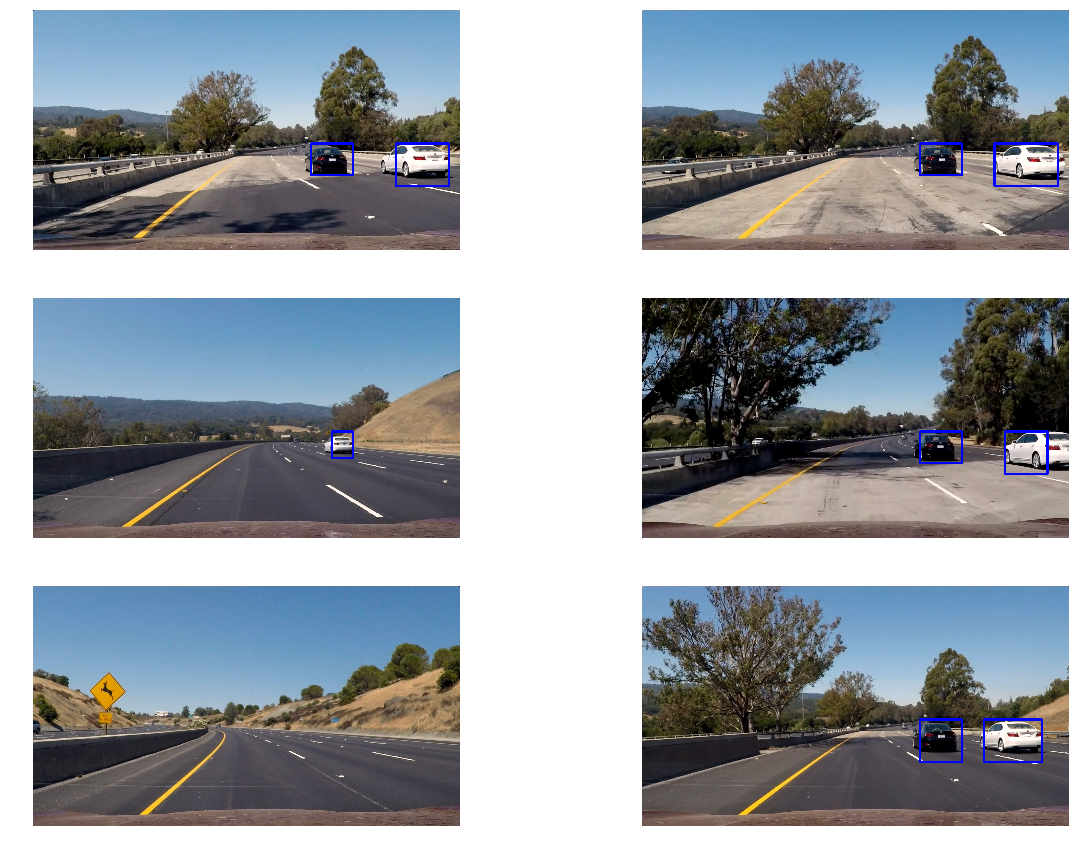

In [100]:
test_images = glob.glob('./test_images/test*.jpg')

fig, vaxis = plt.subplots(3, 2, figsize=(20,15))
vaxis = vaxis.ravel()

for i, imgx in enumerate(test_images):
    vaxis[i].axis('off')
    vaxis[i].imshow(process_frame(mpimg.imread(imgx)))

### Class to Store Data from Vehicle Detections

In [101]:
# Define a class to store data from video
class Detection():
    def __init__(self):
        # history of blocks in previous n frames
        self.prevr = [] 
        
    def addr(self, rects):
        self.prevr.append(rects)
        if len(self.prevr) > 15:
            # throw out oldest block set(s)
            self.prevr = self.prevr[len(self.prevr)-15:]

### Pipeline for Processing Video Frames

In [102]:
def process_frames(img):

    blocks = []

    colorspace = 'YUV' # pick from RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # pick from 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    blocks.append(detect(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    blocks = [item for sublist in blocks for item in sublist] 
    
    # add detections to the history
    if len(blocks) > 0:
        det.addr(blocks)
    
    img_heat = np.zeros_like(img[:,:,0])
    for rect_set in det.prevr:
        img_heat = add_heat(img_heat, rect_set)
    img_heat = apply_threshold(img_heat, 1 + len(det.prevr)//2)
     
    labels = label(img_heat)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

### Run test Video Through the Pipeline

In [103]:
def process_video(inp_vid, out_vid):
    input_vid = VideoFileClip(inp_vid)
    output_vid = input_vid.fl_image(process_frames)
    output_vid.write_videofile(out_vid, audio=False)
    print('Output File Write Complete.')

In [104]:
# Input and output video lists which contains names for reference.
video_input = ['test_video.mp4',  'project_video.mp4']
video_output = ['test_video_out.mp4',  'project_video_out.mp4']
detect1 = Detection()

# Writing Output Video's for both input video files.
for i in range(2):
    process_video(video_input[i], video_output[i])
print('Done')

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:14<00:00,  2.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Output File Write Complete.
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [07:58<00:00,  2.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Output File Write Complete.
Done


In [105]:
# test_video_out.mp4 preview
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output[0]))

In [106]:
# project_video_out.mp4 preview
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output[1]))